# <center>Field-Aware Factorization Machines: Using an ML-based approach to health modeling typically seen in epidemiologic studies</center>

### General Overview

Special thanks to the team (Ma Chao (<span style="color: red;">needs updating</span>)) who built xLearn and also Walter Ngaw (<span style="color: red;">needs updating</span>) for providing the necessary introduction to this type of modeling work. The idea to actually use a FFM (Field-aware Factorization Machine) in this was suggested by my statistics professors due to the longitudinal nature and the sparsity of the data I am using.

Factorization Machines were introduced by Steffen Rendle in 2012, which is a new type of model that combines the advantages of support vector machines with matrix factorization models. It generally works as a predictor like SVMs and can estimate interactions with high sparsity datasets (where SVMs do not do well). 

Now the question you may ask - why approach this problem with a complicated model first?

Well, generally, we can use a variety of models to predict things. Of course, this means even with multi-dimensional data we can use something as simple as simple linear regression to serve as our base.

$\hat{Y}(X) = \hat{\beta}_{0} + \sum \limits _{i=1} ^{n} X_{i}\hat{\beta}_{i} $

To show this expanded for our model we would have something like this:

$ \hat{Y}(X) = \hat{\beta}_{0} + \hat{\beta}_{Income} + \hat{\beta}_{DietQuality} + ... \hat{\beta}_{n} $

Where instead our model would be a logistic regression model modeling for 6-year risk of congestive heart failure represented by $ \hat{Y}(X) $.

However, model misspecification is often an issue in of itself, and this simple linear model (or a simple logistic model) simply cannot capture interactions.

To adjust for this problem, we can deploy what's called an order-2 polynomial model:

$\hat{Y}(X) = \hat{\beta}_{0} + \sum \limits _{i=1} ^{n} X_{i}\hat{\beta}_{i} + \sum _{i=1}^{n}\sum _{j=i+1}^{n}X_{i}X_{j}\hat{\beta}_{ij}$

However, with this model, complexity increases and thus there is now more computational requirements in order to train. With sparse datasets, especially in healthcare data, we will also have a very tough time obtaining enough samples to learn the interactional $ \hat{\beta}_{ij} $.

Here is where factorization machines come in handy. 
An order-2 FM model is defined by this:

$\hat{Y}(X) = \hat{\beta}_{0} + \sum \limits _{i=1} ^{n} X_{i}\hat{\beta}_{i} + \sum _{i=1}^{n}\sum _{j=i+1}^{n}X_{i}X_{j}  (\vec{v}_{i} \cdot \vec{v}_{j})$

### Talk about field-aware factorization machines (<span style="color: red;">needs updating</span>)

### Anyways, all that theory aside, let's try to do some model building and prediction!
Today, we will be using a de-identified big healthcare dataset which includes data on roughly ~77k female participants. The dataset includes information spanning 6-years and is extraodinarily granular in including lifestyle and sociodemographic variables as well as information on various chronic diseases like heart disease, diabetes, heart failure, and etc.
Thus, we will be using these variables to make a prediction on 6-year risk of heart failure, and see how a field-aware factorization machine model can do in terms of classification given its capacity to classify.

In [1]:
#The relative obscurity of field-aware factorization machines means that current packages for this process is simply not up to date.
#We use xlearn to actually fit the model, which requires our python version to be no bigger than 3.7
#We also use recommenders, which only supports up to 3.9

#Therefore, if you want to test this out, I recommend you install pyenv to manage multiple versions
#of python, which currently as of 11/02/2022 is Python 3.11.0. But with pyenv, you can run virtual
#environment versions of python 3.7.0 which accomodates both xlearn and recommenders.
#After you install pyenv: https://www.youtube.com/watch?v=HTx18uyyHw8
#Make sure to use Windows PS to install "pyenv install 3.7.0"
#Set global and local to 3.7.0 (or only local to 3.7.0)
#Configure vscode to accept pyenv and make sure that in VSCode your virtual environment and PS shows
#3.7.0 as the working version of python

#Installing xlearn maybe a challenge but so far the easiest to do is:
# 1. Install visual studio code 15 (2017): https://my.visualstudio.com/Downloads?q=visual%20studio%202017&wt.mc_id=o~msft~vscom~older-downloads
# 2. After installation, install CMake (above ver 3.10): https://cmake.org/download/
# 3. In your code editor or IDE, such as VSCode with jupyter set up, open your terminal and complete the following commands
# git clone https://github.com/aksnzhy/xlearn.git
# cd xlearn
# mkdir build
# cd build
# cmake -G "Visual Studio 15 Win64" ../ "C:\your systems path\vcvarsall.bat" x64 MSBuild xLearn.sln /p:Configuration=Release

#Note - for "C:\your systems path\vcvarsall.bat", this is the path where your Visual Studio 15 is installed
#Mine was "C:\Program Files (x86)\Microsoft Visual Studio\2017\Professional\VC\Auxiliary\Build\vcvarsall.bat"
#Yours will likely be different, so make sure you find the exact path to your Visual Studio 2017's vcvarsall.bat file

#If you're using mac or linux I'm afraid I'm unable to help you with this

In [2]:
#Going to need to import tons of packages
import warnings
warnings.filterwarnings('ignore')

import json
import math
import csv
import os

import numpy as np
import pandas as pd
import seaborn as sns
import recommenders as recommenders
import xlearn as xl

In [3]:
#Imports package to plot our auc scores
from matplotlib import pyplot as plt

#Imports general ML packages to split our data and also calculate eval metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#Importants packages in recommenders which allows us to tune our parameters and also set
#standards during optimization
from recommenders.utils.constants import SEED
from recommenders.utils.timer import Timer
from recommenders.datasets.download_utils import maybe_download, unzip_file
from recommenders.tuning.parameter_sweep import generate_param_grid
from recommenders.datasets.pandas_df_utils import LibffmConverter

In [4]:
#Sets some display options to look at our data with pandas
#Personally I like a much more expanded look than the default 10 lines or so we see where everything is abridged
pd.options.display.max_rows = 10000
pd.set_option('display.max_columns', None)

#Let's load the dataset and then look
rawdat = pd.read_csv('C:/Users/jerry/Desktop/PY_projects/FAFM/readydat_wide_unscale.csv')
rawdat.head(10)

,Unnamed: 0,ID_0,famincome_0,famincome_3,famincome_6,joblvl_0,joblvl_3,joblvl_6,lying_0,lying_3,lying_6,ciglvl_0,ciglvl_3,ciglvl_6,heartf_0,heartf_3,heartf_6,funcability_0,healthiness_0,mentalstate_0,socialbility_0,famedu_0,racethnicity_0,anyhormones_0,coronary_0,mild_0,mild_3,mild_6,moderate_0,moderate_3,moderate_6,hardex_0,hardex_3,hardex_6,walking_0,walking_3,walking_6,hypertension_0,alc_0,agestart_0,dietqual_0,dietqual_3,dietqual_6,funcability_3,funcability_6,healthiness_3,healthiness_6,mentalstate_3,mentalstate_6,socialbility_3,socialbility_6,famedu_3,famedu_6,racethnicity_3,racethnicity_6,anyhormones_3,anyhormones_6,coronary_3,coronary_6,hypertension_3,hypertension_6,alc_3,alc_6,agestart_3,agestart_6,ID_3,ID_6
0,0,100001,4,2,7,1,1,1,3,3,3,3,2,2,0,0,0,70.000000,70.000000,0.001440,100.000000,9,5,0,0,0.0,0.0,0.0,0.00,0.00,0.00,0.00000,0.0,21.00000,1.50,0.00,0.00,0,4,54,77.581950,72.175576,66.634187,70.000000,70.000000,70.000000,70.000000,0.001440,0.001440,100.000000,100.000000,9,9,5,5,0,0,0,0,0,0,4,4,54,54,100001,100001
1,1,100006,6,6,13,1,1,1,4,4,4,2,2,2,0,0,0,100.000000,95.000000,0.002080,100.000000,10,5,1,0,3.0,3.0,0.0,21.00,10.50,4.50,23.33333,17.5,17.50000,3.75,5.25,3.75,0,5,53,74.586544,70.199282,66.634187,100.000000,100.000000,95.000000,95.000000,0.002080,0.002080,100.000000,100.000000,10,10,5,5,1,1,0,0,0,0,5,5,53,53,100006,100006
2,2,100007,4,5,9,1,1,1,5,3,4,3,2,2,0,0,0,82.629177,74.982724,0.038087,90.200569,8,4,1,0,0.0,0.0,0.0,0.00,0.00,0.00,11.66667,0.0,0.00000,3.75,2.50,0.00,0,1,51,67.157033,73.018014,66.634187,82.629177,82.629177,74.982724,74.982724,0.038087,0.038087,90.200569,90.200569,8,8,4,4,1,1,0,0,0,0,1,1,51,51,100007,100007
3,3,100009,8,8,13,0,0,0,3,3,4,2,2,2,0,0,0,82.629177,74.982724,0.001440,90.200569,7,5,1,0,0.0,0.0,0.0,0.00,2.25,4.50,14.00000,10.5,0.00000,3.75,5.00,10.00,0,2,57,74.379379,74.889713,66.634187,82.629177,82.629177,74.982724,74.982724,0.001440,0.001440,90.200569,90.200569,7,7,5,5,1,1,0,0,0,0,2,2,57,57,100009,100009
4,4,100016,5,5,9,0,0,0,4,4,5,4,3,2,0,0,0,90.000000,80.000000,0.001440,100.000000,7,5,1,0,2.5,0.0,0.0,0.00,4.50,0.00,0.00000,0.0,0.00000,17.50,3.75,1.50,0,2,69,61.219086,66.298691,66.634187,90.000000,90.000000,80.000000,80.000000,0.001440,0.001440,100.000000,100.000000,7,7,5,5,1,1,0,0,0,0,2,2,69,69,100016,100016
5,5,100019,3,3,9,1,1,1,3,3,3,3,2,2,0,0,0,100.000000,100.000000,0.001440,100.000000,7,5,0,0,0.0,7.0,21.0,31.50,22.50,21.00,0.00000,0.0,1.16667,17.50,14.00,10.00,0,2,69,88.327711,79.008244,66.634187,100.000000,100.000000,100.000000,100.000000,0.001440,0.001440,100.000000,100.000000,7,7,5,5,0,0,0,0,0,0,2,2,69,69,100019,100019
6,6,100020,3,7,8,0,1,0,4,3,4,2,2,2,0,0,0,85.000000,85.000000,0.045960,100.000000,7,5,0,0,0.0,0.0,0.0,6.75,4.50,0.00,0.00000,0.0,0.00000,2.00,6.25,12.50,0,4,60,76.737441,84.735109,66.634187,85.000000,85.000000,85.000000,85.000000,0.045960,0.045960,100.000000,100.000000,7,7,5,5,0,0,0,0,0,0,4,4,60,60,100020,100020
7,7,100022,6,7,12,1,1,1,4,4,3,3,2,2,0,0,0,50.000000,70.000000,0.166030,75.000000,5,5,1,0,0.0,1.0,0.0,0.00,1.50,4.50,0.00000,0.0,0.00000,2.50,0.00,0.00,0,5,54,63.175503,77.136387,66.634187,50.000000,50.000000,70.000000,70.000000,0.166030,0.166030,75.000000,75.000000,5,5,5,5,1,1,0,0,0,0,5,5,54,54,100022,100022
8,8,100023,5,4,10,0,0,0,5,4,4,5,2,2,0,0,0,90.000000,70.000000,0.002500,100.000000,9,5,1,0,0.0,0.0,0.0,0.00,0.00,2.25,0.00000,0.0,0.00000,0.00,2.00,0.00,0,5,56,37.159959,56.108323,66.634187,90.000000,90.000000,70.000000,70.000000,0.002500,0.002500,100.000000,100.000000,9,9,5,5,1,1,0,0,0,0,5,5,56,56,100023,100023
9,9,100026,4,4,8,0,0,0,4,4,4,3,2,2,0,0,0,65.000000,70.000000,0.001310,50.000000,7,5,0,1,0.0,0.0,0.0,4.50,0.00,0.00,0.00000,0.0,0.00000,7.50,7.50,10.00,2,3,61,60.852869,69.202528,66.634187,65.000000,65.000000,70.000000,70.000000,0.001310,0.001310,50.000000,50.000000,7,7,5,5,0,0,1,1,2,2,3,3,61,61,100026,100026


In [5]:
#For the sake of this project and its length, I'm going to skip much of the data exploration and wrangling.

#As we can see when we take a look at the raw data that there are going to few variables which are not needed
#because they are either articles during data wrangling process or variables that are of the same time frame as
#our outcome (at year 6). So we should drop them to get a more intuitively useful dataset that is clean for analysis.
#After dropping unnecessary variables, we will now have our raw dataset.

rawdat_clean = rawdat.drop(['Unnamed: 0', 'joblvl_6', 'ID_0', 'ID_3', 'ID_6', 'mild_6', 'moderate_6', 'hardex_6', 'walking_6', 'dietqual_6',
           'funcability_6', 'healthiness_6', 'mentalstate_6', 'socialbility_6', 'anyhormones_6', 'coronary_6', 'agestart_6', 'hypertension_6', 'famincome_6',
           'ciglvl_6', 'lying_6',
           'famedu_6', 'alc_6',
           'racethnicity_6'], axis=1)

In [6]:
#Here we create our training, testing, and validation datasets.
X_train, X_test= train_test_split(rawdat_clean, test_size = 0.3, random_state = 5)
X_train2, X_val = train_test_split(X_train, test_size = 0.2, random_state = 5)

In [7]:
#In order to use our data for FFM, we must encode it into FFM readable format. This is a function to encode our csv data
#into the format that FFM needs in order to run.
def _convert_to_ffm(path, df, type, target, numerics, categories, features, encoder):
    # Flagging categorical and numerical fields
    print('convert_to_ffm - START')
    for x in numerics:
        if(x not in encoder['catdict']):
            print(f'UPDATING CATDICT: numeric field - {x}')
            encoder['catdict'][x] = 0
    for x in categories:
        if(x not in encoder['catdict']):
            print(f'UPDATING CATDICT: categorical field - {x}')
            encoder['catdict'][x] = 1

    nrows = df.shape[0]
    with open(path + str(type) + "_ffm.txt", "w") as text_file:

        # Looping over rows to convert each row to libffm format
        for n, r in enumerate(range(nrows)):
            datastring = ""
            datarow = df.iloc[r].to_dict()
            datastring += str(int(datarow[target]))  # Set Target Variable here

            # For numerical fields, we are creating a dummy field here
            for i, x in enumerate(encoder['catdict'].keys()):
                if(encoder['catdict'][x] == 0):
                    # Not adding numerical values that are nan
                    if math.isnan(datarow[x]) is not True:
                        datastring = datastring + " "+str(i)+":" + str(i)+":" + str(datarow[x])
                else:

                    # For a new field appearing in a training example
                    if(x not in encoder['catcodes']):
                        print(f'UPDATING CATCODES: categorical field - {x}')
                        encoder['catcodes'][x] = {}
                        encoder['currentcode'] += 1
                        print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    # For already encoded fields
                    elif(datarow[x] not in encoder['catcodes'][x]):
                        encoder['currentcode'] += 1
                        print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    code = encoder['catcodes'][x][datarow[x]]
                    datastring = datastring + " "+str(i)+":" + str(int(code))+":1"

            datastring += '\n'
            text_file.write(datastring)

    # print('Encoder Summary:')
    # print(json.dumps(encoder, indent=4))
    return encoder


In [8]:
#Here, we define our outcomes and the types of features.
GOAL = ['heartf_6']
NUMERICAL_FEATURES = ['funcability_0', 'healthiness_0', 'mentalstate_0', 'socialbility_0', 'mild_0', 'mild_3', 'moderate_0', 'moderate_3', 'hardex_0', 'hardex_3', 'walking_0', 'walking_3','agestart_0', 'dietqual_0', 'dietqual_3', 'funcability_3', 'healthiness_3', 'mentalstate_3', 'socialbility_3','agestart_3']
CATEGORICAL_FEATURES = ['famincome_0', 'famincome_3', 'joblvl_0', 'joblvl_3', 'lying_0', 'lying_3', 'ciglvl_0', 'ciglvl_3', 'heartf_0', 'heartf_3','famedu_0', 'racethnicity_0', 'anyhormones_0', 'coronary_0','hypertension_0', 'alc_0','famedu_3', 'racethnicity_3', 'anyhormones_3', 'coronary_3', 'hypertension_3', 'alc_3']
ALL_FEATURES = ['famincome_0', 'famincome_3', 'joblvl_0', 'joblvl_3', 'lying_0', 'lying_3', 'ciglvl_0', 'ciglvl_3', 'heartf_0', 'heartf_3', 'heartf_6', 'funcability_0', 'healthiness_0', 'mentalstate_0', 'socialbility_0', 'famedu_0', 'racethnicity_0', 'anyhormones_0', 'coronary_0', 'mild_0', 'mild_3', 'moderate_0', 'moderate_3', 'hardex_0', 'hardex_3', 'walking_0', 'walking_3', 'hypertension_0', 'alc_0', 'agestart_0', 'dietqual_0', 'dietqual_3', 'funcability_3', 'healthiness_3', 'mentalstate_3', 'socialbility_3', 'famedu_3', 'racethnicity_3', 'anyhormones_3', 'coronary_3', 'hypertension_3', 'alc_3', 'agestart_3']
NUM_THREADS = 8

In [9]:
#Now let's encode our data using the function we defined above.
encoder = {"currentcode": len(NUMERICAL_FEATURES),
           "catdict": {},
           "catcodes": {}}

encoder = _convert_to_ffm('C:/Users/jerry/Desktop/PY_projects/FAFM/', X_train, 'train', GOAL[0],
                          NUMERICAL_FEATURES,
                          CATEGORICAL_FEATURES,
                          ALL_FEATURES,
                          encoder)

encoder = _convert_to_ffm('C:/Users/jerry/Desktop/PY_projects/FAFM/', X_test, 'test', GOAL[0],
                          NUMERICAL_FEATURES,
                          CATEGORICAL_FEATURES,
                          ALL_FEATURES,
                          encoder)

encoder = _convert_to_ffm('C:/Users/jerry/Desktop/PY_projects/FAFM/', X_val, 'valid', GOAL[0],
                          NUMERICAL_FEATURES,
                          CATEGORICAL_FEATURES,
                          ALL_FEATURES,
                          encoder)

convert_to_ffm - START
UPDATING CATDICT: numeric field - funcability_0
UPDATING CATDICT: numeric field - healthiness_0
UPDATING CATDICT: numeric field - mentalstate_0
UPDATING CATDICT: numeric field - socialbility_0
UPDATING CATDICT: numeric field - mild_0
UPDATING CATDICT: numeric field - mild_3
UPDATING CATDICT: numeric field - moderate_0
UPDATING CATDICT: numeric field - moderate_3
UPDATING CATDICT: numeric field - hardex_0
UPDATING CATDICT: numeric field - hardex_3
UPDATING CATDICT: numeric field - walking_0
UPDATING CATDICT: numeric field - walking_3
UPDATING CATDICT: numeric field - agestart_0
UPDATING CATDICT: numeric field - dietqual_0
UPDATING CATDICT: numeric field - dietqual_3
UPDATING CATDICT: numeric field - funcability_3
UPDATING CATDICT: numeric field - healthiness_3
UPDATING CATDICT: numeric field - mentalstate_3
UPDATING CATDICT: numeric field - socialbility_3
UPDATING CATDICT: numeric field - agestart_3
UPDATING CATDICT: categorical field - famincome_0
UPDATING CATDIC

In [14]:
#Here, we train a very basic ffm model and then create predictions. We will then generate one AUC score to see how it does.
ffm_model = xl.create_ffm()
ffm_model.setTrain("C:/Users/jerry/Desktop/PY_projects/FAFM/train_ffm.txt")

param = {'task': 'binary',
         'lr': 0.01,
         'lambda': 0.00002,
         'metric': 'auc'}

ffm_model.setTXTModel("C:/Users/jerry/Desktop/PY_projects/FAFM/model.txt")
ffm_model.fit(param, 'C:/Users/jerry/Desktop/PY_projects/FAFM/model.out')
ffm_model.cv(param)

# Prediction task
ffm_model.setSigmoid()
ffm_model.setTest("C:/Users/jerry/Desktop/PY_projects/FAFM/test_ffm.txt") # Test data

# Start to predict
# The output result will be stored in output.txt
ffm_model.predict("C:/Users/jerry/Desktop/PY_projects/FAFM/model.out", "C:/Users/jerry/Desktop/PY_projects/FAFM/output.txt")

In [15]:
#Here, we create the file necessary to obtain our AUC score.
test_file = os.path.join("C:/Users/jerry/Desktop/PY_projects/FAFM/", "test_ffm.txt")
output_file = os.path.join("C:/Users/jerry/Desktop/PY_projects/FAFM/", "output.txt")
with open(output_file) as f:
    predictions = f.readlines()

with open(test_file) as f:
    truths = f.readlines()

truths = np.array([float(truth.split(' ')[0]) for truth in truths])
predictions = np.array([float(prediction.strip('')) for prediction in predictions])

auc_score = roc_auc_score(truths, predictions)
print("Our simple model's AUC score is: " + str(auc_score) + ".")

Our simple model's AUC score is: 0.7547836766747023.


In [10]:
#Now let's do some parameter tuning. Because my computer can only handle
# certain amounts of memory (I am using a horrendously uncompetitive laptop with only 8gb of ram and 250gb of space),
# I am only able to effectively tune with two dimensions... which is why you see that I am only tuning learning rate
# and lambda.

param_dict = {
    "lr": [0.000001, 0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.01, 0.02, 0.03, 0.04, 0.1, 0.2, 0.3, 0.5],
    "lambda": [0.0000001, 0.000001, 0.000005, 0.00001, 0.002, 0.003, 0.004, 0.001, 0.01, 0.02, 0.03, 0.04, 0.1, 0.2, 0.3]
}

param_grid = generate_param_grid(param_dict)

In [11]:
#import additional files that's needed for tuning in xlearn.
test_file = os.path.join("C:/Users/jerry/Desktop/PY_projects/FAFM/", "test_ffm.txt")
output_file = os.path.join("C:/Users/jerry/Desktop/PY_projects/FAFM/", "output.txt")
train_file = os.path.join("C:/Users/jerry/Desktop/PY_projects/FAFM/", "train_ffm.txt")
valid_file = os.path.join("C:/Users/jerry/Desktop/PY_projects/FAFM/", "valid_ffm.txt")
model_file = os.path.join("C:/Users/jerry/Desktop/PY_projects/FAFM/", "model.out")

In [12]:
auc_scores = []
params = []

with Timer() as time_tune:
    for param in param_grid:
        ffm_model = xl.create_ffm()       
        ffm_model.setTrain(train_file)     
        ffm_model.setValidate(valid_file)
        ffm_model.fit(param, model_file)
        ffm_model.setTest(test_file)  
        ffm_model.setSigmoid()        
        ffm_model.predict(model_file, output_file)

        with open(output_file) as f:
            predictions = f.readlines()

        with open(test_file) as f:
            truths = f.readlines()

        truths = np.array([float(truth.split(' ')[0]) for truth in truths])
        predictions = np.array([float(prediction.strip('')) for prediction in predictions])

        auc_scores.append(roc_auc_score(truths, predictions))
        params.append(param)

print('Tuning by grid search takes {0:.2} min'.format(time_tune.interval / 60))

Tuning by grid search takes 3.1e+01 min


<AxesSubplot:xlabel='lambda', ylabel='lr'>

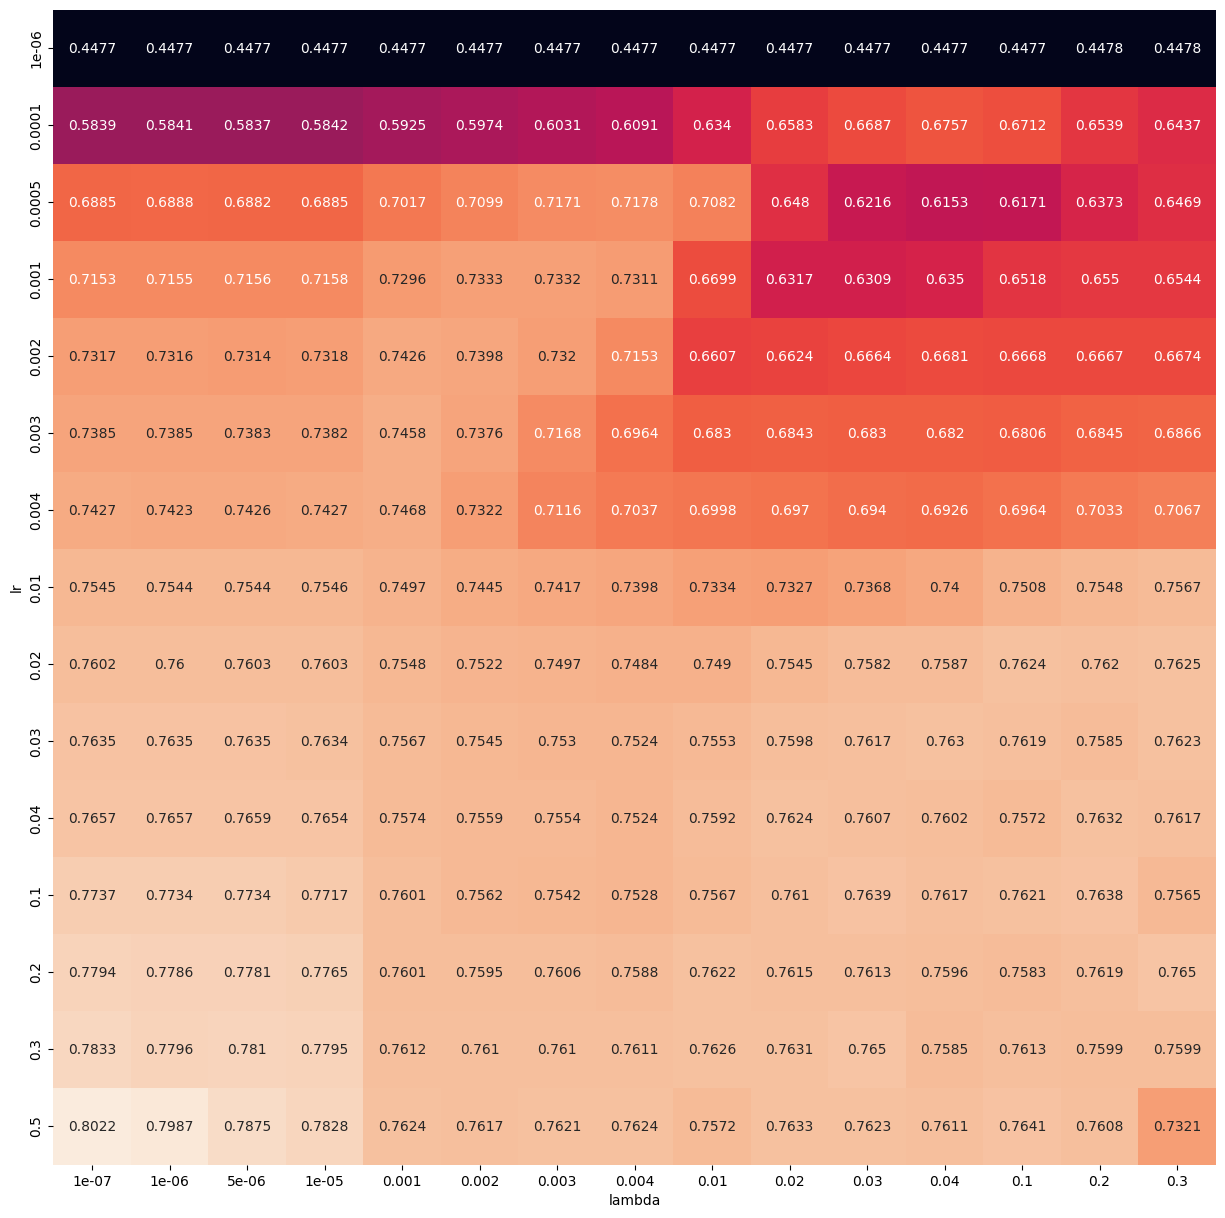

In [14]:
#Now let's get our list of auc scores generated into an object suitable to generate a heat-map
auc_scores = [float('%.4f' % x) for x in auc_scores]

auc_df = pd.DataFrame(auc_scores, columns=['auc']) 
param_df = pd.DataFrame(params)

auc_df
auc_df['id'] = auc_df.index

param_df
param_df['id'] = param_df.index

auc_param = pd.merge(auc_df, param_df, on="id")
auc_param

#Let's generate a visual heat map of the combinations of lambda and learning rates
#and their corresponding auc scores
fig, ax = plt.subplots(figsize=(15,15))
auc_plot = auc_param.pivot("lr", "lambda", "auc")
sns.heatmap(auc_plot, cbar=False, annot=True, fmt=".4g")

In [15]:
# Now let's turn our auc scores and the parameters into a dataframe so we can find the best score and parameters
auc_df = pd.DataFrame(auc_scores, columns=['auc']) 
param_df = pd.DataFrame(params)

auc_df
auc_df['id'] = auc_df.index

param_df
param_df['id'] = param_df.index

auc_param = pd.merge(auc_df, param_df, on="id")
auc_param

idx=auc_param.set_index('auc').index.get_loc(auc_param['auc'].max())
print('The best auc score of our model is: ' + str(auc_param.iat[idx,0]) + '.' +
        '\nThe learning rate is: ' + str(auc_param.iat[idx,1]) + '.' +
        '\nThe lambda is: ' + str(auc_param.iat[idx,2]) + '.')

The best auc score of our model is: 0.8022.
The learning rate is: 14.
The lambda is: 1e-07.


In [10]:
#Now for the next part, this is intended ONLY if you have a good enough machine (graphics, cpu, enough memory (>32/64gb))
#Or else the program will likely crash

# We can go through the full sequence of tune-able parameters given by xlearn doc by grid searching
# Like I said, if you have the appropriate machine then the follow parameters are completely do-able
    # "lr": [0.000001, 0.0001, 0.001, 0.002, 0.003, 0.004, 0.01, 0.02, 0.03, 0.04, 0.1, 0.2, 0.3, 0.5],
    # "lambda": [0.000001, 0.00001, 0.002, 0.003, 0.004, 0.001, 0.01, 0.02, 0.03, 0.04, 0.1, 0.2, 0.3],
    # "task" : ["binary"],
    # "k" : [2,3,4,5,6,7,8,9],
    # "init" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    # "opt" : ["sgd", "adagrad"]

# But if not, this is a more simplified version that still allows us to "tune" more than just learning rate and lambda.
ffm_model = xl.FFMModel()
param_dict = {
    "lr": [0.0001, 0.001],
    "lambda": [0.000001, 0.00001],
    "task" : ["binary"],
    "k" : [1,2,6,9],
    "init" : [0.1, 0.2, 0.7, 0.9],
    "opt" : ["sgd", "adagrad"]
}

param_grid = generate_param_grid(param_dict)

In [11]:
#import additional files
test_file = os.path.join("C:/Users/jerry/Desktop/PY_projects/FAFM/", "test_ffm.txt")
output_file = os.path.join("C:/Users/jerry/Desktop/PY_projects/FAFM/", "output.txt")
train_file = os.path.join("C:/Users/jerry/Desktop/PY_projects/FAFM/", "train_ffm.txt")
valid_file = os.path.join("C:/Users/jerry/Desktop/PY_projects/FAFM/", "valid_ffm.txt")
model_file = os.path.join("C:/Users/jerry/Desktop/PY_projects/FAFM/", "model.out")

In [12]:
auc_scores = []
params = []

with Timer() as time_tune:
    for param in param_grid:
        ffm_model = xl.create_ffm()       
        ffm_model.setTrain(train_file)     
        ffm_model.setValidate(valid_file)
        ffm_model.fit(param, model_file)
        ffm_model.setTest(test_file)  
        ffm_model.setSigmoid()        
        ffm_model.predict(model_file, output_file)

        with open(output_file) as f:
            predictions = f.readlines()

        with open(test_file) as f:
            truths = f.readlines()

        truths = np.array([float(truth.split(' ')[0]) for truth in truths])
        predictions = np.array([float(prediction.strip('')) for prediction in predictions])

        auc_scores.append(roc_auc_score(truths, predictions))
        params.append(param)

print('Tuning by grid search takes {0:.2} min'.format(time_tune.interval / 60))

Tuning by grid search takes 1e+01 min


In [13]:
#Once again we now must make a dataframe and find our best parameters.
auc_df = pd.DataFrame(auc_scores, columns=['auc']) 
param_df = pd.DataFrame(params)

auc_df
auc_df['id'] = auc_df.index

param_df
param_df['id'] = param_df.index

auc_param = pd.merge(auc_df, param_df, on="id")

idx=auc_param.set_index('auc').index.get_loc(auc_param['auc'].max())
print('The best auc score of our model is: ' + str(auc_param.iat[idx,0]) + '.' +
        '\nThe learning rate is: ' + str(auc_param.iat[idx,5]) + '.' +
        '\nThe lambda is: ' + str(auc_param.iat[idx,4]) + '.' + 
        '\nThe k is: ' + str(auc_param.iat[idx,3]) + '.' + 
        '\nThe initialization is: ' + str(auc_param.iat[idx,2]) + '.' +
        '\nThe optimizer used is: ' + str(auc_param.iat[idx,6]) + '.' +
        '\nAnd the task used is: ' + str(auc_param.iat[idx,7]) + '.')

The best auc score of our model is: 0.7547757779969317.
The learning rate is: 0.001.
The lambda is: 1e-05.
The k is: 6.
The initialization is: 0.1.
The optimizer used is: sgd.
And the task used is: binary.


## Summary

As you see, when I tuned only learning rate and lambda exhaustively, our best AUC was 0.80. With an increased list of parameters to tune, I only achieved 0.75. With a more capable machine with increased computational capacity, I would imagine that we can find an even better set of parameters that would allow us to achieve > 0.80 AUC. However, in 2022 that may cost > $10k. But, the attempt to illustrate the possibility of FFM is nevertheless demonstrated and this form of modeling predictions could be a useful toolset in any healthcare researchers attempting to make classification related predictions with datasets that are sparse. The ability for FFM to efficiently model interacting features is an additional bonus that can perhaps allow us to granularly account for various dependencies that otherwise maybe too complex to do by hand.

## Epilogue (<span style="color: red;">needs updating</span>)
With this I would like to end on a couple of notes:
Epidemiological problems and the type of designs necessary to model disease and health are increasingly complex as we have more access to data.
The features in this dataset were hand picked, and are of course subject to anyone's scrutiny. For example, the general socialness of an individual (socialbility) as a valuable predictor of someone's heart failure risk can be argued as either important or un-important depending the arguments used.
Domain experts and their knowledge, at this point (and maybe forever), are un-replaceable. This knowledge not only allows one to properly assess whether predictions and associations are meaningful in the causal context, but also can help provide guidance on feature selections during model building.
Great models will never outdo poor data.